In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.7 MB/s 
     |████████████████████████████████| 6.3 MB 35.2 MB/s 
     |████████████████████████████████| 16.7 MB 53.4 MB/s 


In [158]:
import pandas as pd
import geopandas as gpd
import json
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np

In [159]:
db = pd.read_csv("/content/drive/MyDrive/Projects/PlastOPol/Datasets/database.csv")
rydde = db[931:17798]

In [160]:
gdf = gpd.GeoDataFrame(rydde, geometry=gpd.points_from_xy(rydde.longitude, rydde.latitude))

In [161]:
gdf.date = pd.to_datetime(gdf.date)

In [162]:
#Svinøya 30x30
lat_min = 62.345252708439276
lat_max = 62.61474729156072
lng_min = 5.978375939307136
lng_max = 6.561624060692863
cell_rows, cell_columns = 16, 16

In [163]:
def generateCells(lat_min, lng_min, lat_max, lng_max, cell_rows, cell_columns):
    half_cell_height = (lat_max - lat_min) / (2 * (cell_rows - 1))
    half_cell_width = (lng_max - lng_min) / (2 * (cell_columns - 1))
    lat_point = lat_min
    row_count = 0
    cells = []
    while (row_count < cell_rows):
        lng_point = lng_min
        column_count = 0
        while (column_count < cell_columns):
            lat_0 = lat_point - half_cell_height
            lng_0 = lng_point - half_cell_width
            lat_1 = lat_point + half_cell_height
            lng_1 = lng_point + half_cell_width
            cells.append({"lng_min":lng_0, "lat_min": lat_0, "lat_max":lat_1, "lng_max":lng_1})
            lng_point += 2 * half_cell_width
            column_count+=1
        lat_point += 2 * half_cell_height
        row_count+=1
    return cells
    

In [164]:
cells = generateCells(lat_min, lng_min, lat_max, lng_max, cell_rows, cell_columns)

In [165]:
def getCellData(cell):
        data = gdf.cx[cell["lng_min"]: cell["lng_max"], cell["lat_min"] : cell["lat_max"]]
        return data

In [166]:
def createBoundsDf(cells):
    i = 0;
    udf = pd.DataFrame(columns=["date", "boundsId", "weight", "quantity"])
    for cell in cells:
        data = getCellData(cell)
        # print(data)
        newdf = pd.DataFrame(data)
        newdf["boundsId"] = i
        newdf = newdf[["date", "boundsId", "weight", "quantity"]]
        udf = udf.append(newdf, ignore_index=True)
        i+=1
    return udf

In [167]:
bdf = createBoundsDf(cells)
bdf.head()

,date,boundsId,weight,quantity
0,2018-04-10 02:00:00,2,1000.0,NaN
1,2020-05-14 02:00:00,15,500.0,NaN
2,2017-09-16 02:00:00,17,1450.0,NaN
3,2019-07-01 02:00:00,17,700.0,NaN
4,2018-05-06 02:00:00,17,220.0,NaN


In [170]:
from sklearn import preprocessing

new_bdf = bdf.sort_values(by="date")
new_bdf["weight"] = new_bdf["weight"].replace(np.nan, 0.0)

def normalize(df, feature_name):
    result = df.copy()
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


new_bdf = normalize(new_bdf, "weight")


In [171]:
# new_bdf.set_index("date")
term_date = datetime.datetime(2019, 1, 1)
temp = new_bdf[new_bdf["date"]< term_date]
temp["weight"] = temp["weight"].replace(np.nan, 0.0)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


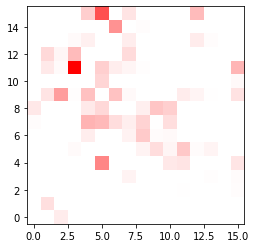

In [172]:
temp_data = np.zeros((16, 16))

for i in range(len(temp)):
  id = temp["boundsId"].iloc[i]
  row = int(id/16)
  col = int(id%16)
  # print(row, col)
  if temp["weight"].iloc[i]:
    temp_data[row, col] = temp_data[row, col] +  temp["weight"].iloc[i]

temp_data

N = 256
vals = np.ones((N, 3))
vals[:, 0] = np.linspace(0, 1, 1)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 1, N)
newcmp = ListedColormap((2+(vals*-2))/2)
# newcmp = ListedColormap(vals)
# print((2+(vals*-2))/2)
# print(vals)

plt.imshow(temp_data, cmap=newcmp, interpolation='nearest', origin="lower")
plt.show()
# print(temp_data)

In [173]:
def generate_heatmaps(df):
  Years = list(range(2014, 2021))
  Months = list(range(1,13))
  monthly_heatmaps = []
  for year in Years:
    for month in Months:
      stop_date = datetime.datetime(year,month,1)
      filtered_data = df[df["date"]<stop_date]
      # filtered_data["weight"] = filtered_data["weight"].replace(np.nan, 0.0)
      temp_data = np.zeros((16, 16))
      # print(stop_date)
      for i in range(len(filtered_data)):
        pass
        id = filtered_data.iloc[i]["boundsId"]
        row = int(id/16)
        col = int(id%16)
        # print(row, col)
        if filtered_data["weight"].iloc[i]:
          temp_data[row, col] = temp_data[row, col] +  filtered_data.iloc[i]["weight"]

      monthly_heatmaps.append((temp_data))
  # not normalized yet
  return monthly_heatmaps


In [174]:
heatmaps = generate_heatmaps(new_bdf)
new_data = np.array(heatmaps)
print(new_data.shape)
# print(heatmaps[-1])

(84, 16, 16)


In [175]:
train_ratio = 0.75

train_size = int(len(new_data) * train_ratio)
test_size = len(new_data) - train_size
train = new_data[0:train_size,:]
test = new_data[train_size:len(new_data),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 63, test size: 21 


In [189]:
seq_len = 4
seq_future = 1
# dataX = []
# dataY = []
# for i in range(len(train)-seq_len-1):
#     a = train[i:(i+seq_len), :, :]
#     dataX.append(a)
#     dataY.append(train[i + seq_len, :, :])
# trainX = np.array(dataX)
# trainX = trainX[::, ::, ::, ::, np.newaxis]
# trainY = np.array(dataY)
# trainY = trainY[::, ::, ::, np.newaxis]

# dataX = []
# dataY = []
# for i in range(len(test)-seq_len-1):
#     a = test[i:(i+seq_len), :, :]
#     dataX.append(a)
#     dataY.append(test[i + seq_len, :,:])

# # dataX = [dataX]
# # dataY = [:,dataX]
# testX = np.array(dataX)
# testX = testX[::, ::, ::, ::, np.newaxis]
# testY = np.array(dataY)
# testY = testY[::, ::, ::, np.newaxis]



dataX = []
dataY = []
for i in range(len(train)-seq_len-1):
    a = train[i:(i+seq_len), :, :]
    dataX.append(a)
    dataY.append(train[i+seq_future: (i + seq_future +seq_len), :, :])
trainX = np.array(dataX)
trainX = trainX[::, ::, ::, ::, np.newaxis]
trainY = np.array(dataY)
trainY = trainY[::, ::, ::,::, np.newaxis]

dataX = []
dataY = []
for i in range(len(test)-seq_len-1):
    a = test[i:(i+seq_len), :, :]
    dataX.append(a)
    dataY.append(test[i+seq_future: (i + seq_future +seq_len), :, :])

# dataX = [dataX]
# dataY = [:,dataX]
testX = np.array(dataX)
testX = testX[::, ::, ::, ::, np.newaxis]
testY = np.array(dataY)
testY = testY[::, ::, ::, ::, np.newaxis]


print('shape of trainX: ', trainX.shape)
print('shape of testX: ', testX.shape)
print('shape of trainY: ', trainY.shape)
print('shape of testY: ', testY.shape)

shape of trainX:  (58, 4, 16, 16, 1)
shape of testX:  (16, 4, 16, 16, 1)
shape of trainY:  (58, 4, 16, 16, 1)
shape of testY:  (16, 4, 16, 16, 1)


In [190]:
trainX[np.isnan(trainX)] = 0
testX[np.isnan(testX)] = 0
testX[np.isnan(testX)] = 0
testY[np.isnan(testY)] = 0


In [178]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import ConvLSTM2D, Conv3D
import keras
from keras.callbacks import EarlyStopping

In [192]:
seq = Sequential(
    [
     keras.Input(
         shape=(None, 16, 16, 1)
     ),
     ConvLSTM2D(filters=3, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=3, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=3, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=3, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     Conv3D(filters=1, kernel_size=(3,3,3), activation="sigmoid", padding="same"),
    ]
)

seq.compile(loss="binary_crossentropy", optimizer="adam")
seq.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_54 (ConvLSTM2D)  (None, None, 16, 16, 3)  204       
                                                                 
 batch_normalization_55 (Bat  (None, None, 16, 16, 3)  12        
 chNormalization)                                                
                                                                 
 conv_lstm2d_55 (ConvLSTM2D)  (None, None, 16, 16, 3)  300       
                                                                 
 batch_normalization_56 (Bat  (None, None, 16, 16, 3)  12        
 chNormalization)                                                
                                                                 
 conv_lstm2d_56 (ConvLSTM2D)  (None, None, 16, 16, 3)  300       
                                                                 
 batch_normalization_57 (Bat  (None, None, 16, 16, 3)

In [193]:
epoch = 50

history = seq.fit(
    trainX,
    trainY,
    batch_size=1,
    # validation_split=0.1
    epochs=epoch,
    validation_data = (testX, testY), shuffle=False
)

Epoch 1/50
58/58 [==============================] - 10s 43ms/step - loss: 0.6071 - val_loss: 0.6306
Epoch 2/50
58/58 [==============================] - 2s 27ms/step - loss: 0.2987 - val_loss: 0.5586
Epoch 3/50
58/58 [==============================] - 2s 26ms/step - loss: 0.1313 - val_loss: 0.5477
Epoch 4/50
58/58 [==============================] - 2s 26ms/step - loss: 0.0794 - val_loss: 0.6783
Epoch 5/50
58/58 [==============================] - 2s 27ms/step - loss: 0.0600 - val_loss: 0.9848
Epoch 6/50
58/58 [==============================] - 2s 27ms/step - loss: 0.0502 - val_loss: 1.2770
Epoch 7/50
58/58 [==============================] - 2s 27ms/step - loss: 0.0443 - val_loss: 1.2833
Epoch 8/50
58/58 [==============================] - 2s 26ms/step - loss: 0.0403 - val_loss: 0.9978
Epoch 9/50
58/58 [==============================] - 2s 26ms/step - loss: 0.0377 - val_loss: 0.6294
Epoch 10/50
58/58 [==============================] - 2s 27ms/step - loss: 0.0359 - val_loss: 0.3556
Epoch 11

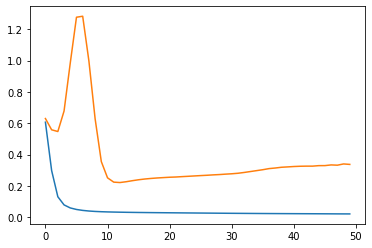

In [194]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [201]:
predicted = seq.predict(testX)
predicted.shape

(16, 4, 16, 16, 1)

In [202]:
predicted = np.squeeze(predicted, axis =4)
predicted.shape

(16, 4, 16, 16)

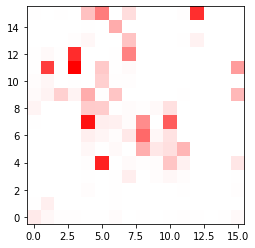

In [205]:
predicted_instance = predicted[0][0]

N = 256
vals = np.ones((N, 3))
vals[:, 0] = np.linspace(0, 1, 1)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 1, N)
newcmp = ListedColormap((2+(vals*-2))/2)
# newcmp = ListedColormap(vals)
# print((2+(vals*-2))/2)
# print(vals)

plt.imshow(predicted_instance, cmap=newcmp, interpolation='nearest', origin="lower")
plt.show()
# print(temp_data)


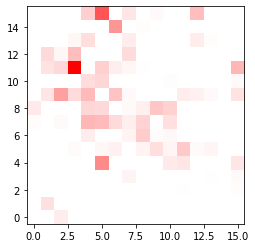

In [208]:
ground_truth = np.squeeze(testY, axis =4)
true_instance = ground_truth[0][0]
plt.imshow(true_instance, cmap=newcmp, interpolation='nearest', origin="lower")
plt.show()